In [1]:
import sys
sys.path.append('../.')


from utils import *
from Data.DataGenerator import *
from Models.Models_normal import *
import torch.optim as optim
from Training.Analysis import fixed_model_batch_analysis
from Data.DataLoader import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering, BisectingKMeans
from sklearn.linear_model import RANSACRegressor
from tqdm import tqdm
import numpy as np
import itertools
from sklearn.linear_model import RANSACRegressor


In [2]:
# Load the model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
arch = (784, [256, 128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10])

model = MNIST_classifier(n_in=arch[0], layer_list=arch[1], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 32, 16, 8, 3], bias=0)
# model = MNIST_classifier(n_in=784, layer_list=[128, 128, 128, 64, 64, 64, 64, 64, 64, 32, 10], bias=0)

state_dict = torch.load('/home/mila/m/mehrab.hamidi/scratch/training_res/november_res/mnist/normal/bias_0.0001/mnist_training/try_num2/epoch_120/model.pt', weights_only=False)
model.load_state_dict(state_dict)

model.eval()


# load the data
_, _, _, train_samples, train_labels, val_samples, val_labels, test_samples, test_labels = get_mnist_data_loaders()



dataset_target_samples = train_samples
dataset_target_labels = train_labels

Train Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Validation Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Test Loader Batch Shapes:
Batch 1: Images Shape = torch.Size([64, 1, 28, 28]), Labels Shape = torch.Size([64])

Train Samples Shape: torch.Size([50000, 784])
Train Labels Shape: torch.Size([50000])

Validation Samples Shape: torch.Size([10000, 784])
Validation Labels Shape: torch.Size([10000])

Test Samples Shape: torch.Size([10000, 784])
Test Labels Shape: torch.Size([10000])

Train Label Frequencies: Counter({1: 5678, 7: 5175, 3: 5101, 9: 4988, 2: 4968, 6: 4951, 0: 4932, 4: 4859, 8: 4842, 5: 4506})
Validation Label Frequencies: Counter({7: 1090, 1: 1064, 3: 1030, 8: 1009, 0: 991, 2: 990, 4: 983, 6: 967, 9: 961, 5: 915})
Test Label Frequencies: Counter({1: 1135, 2: 1032, 7: 1028, 3: 1010, 9: 1009, 4: 982, 0: 980, 8: 974, 6: 958, 5: 892})


In [3]:
def plot_data_projection(ax, counter, anim_pieces, type_analysis='pca', dim=2, title='layers: ', labels_all: list = []):

    labels = labels_all[0]
    
    # Find unique labels and the number of unique classes
    unique_labels = np.unique(labels)
    num_classes = len(unique_labels)
    
    # Dynamically select an appropriate colormap
    if num_classes <= 10:
        cmap = plt.get_cmap('tab10')  # type: ignore # Use tab10 for 10 or fewer classes
    elif num_classes <= 20:
        cmap = plt.get_cmap('tab20')  # type: ignore # Use tab20 for 11-20 classes
    else:
        cmap = plt.cm.get_cmap('viridis', num_classes)  # type: ignore # Use continuous colormap for more than 20 classes
    
    # Map each unique label to a specific color in the colormap
    color_map = {label: cmap(i / num_classes) for i, label in enumerate(unique_labels)}
    
    # Assign colors to each data point based on its label
    colors = [color_map[label] for label in labels]
    
    # Select appropriate scatter plot based on dimension
    if dim == 2:
        ax.scatter(anim_pieces[counter][0], anim_pieces[counter][1], c=colors, s=10)
    elif dim == 3:
        ax.scatter(anim_pieces[counter][0], anim_pieces[counter][1], anim_pieces[counter][2], c=colors, s=10)
    
    # If labels are provided, add a legend
    if labels is not None:
        # Create a list of legend handles
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label],  # type: ignore
                              markersize=8, label=f'Class {label}') for label in unique_labels]
        
        # Add the legend to the axis
        ax.legend(handles=handles, title="Classes", loc="best")
    
    ax.grid(True)

    if type_analysis == 'pca':
        ax.set_xlabel('First Principal Component')
        ax.set_ylabel('Second Principal Component')
        if dim == 2:
            # ax.quiver([0, 0], eigenvectors[0][:, -1][0], eigenvectors[0][:, -1][1])
            # ax.quiver([0, 0], eigenvectors[0][:, -2][0], eigenvectors[0][:, -2][1])
            ax.set_title('Data in First Two Principal Components')
        if dim == 3:
            ax.set_zlabel('Third Principal Component')
            ax.set_title('Data in First Three Principal Components')
    elif type_analysis == 'random':
        ax.set_xlabel('First Random Diemnsion')
        ax.set_ylabel('Second Random Dimension')
        ax.set_title('Data in Two Random Dimension')
        if dim == 2:
            ax.set_title('Data in Two Random Dimension')
        if dim == 3:
            ax.set_zlabel('Third Random Dimension')
            ax.set_title('Data in Three Random Dimension')
    if type(title) is list:
        ax.set_title(title[counter])
    else:
        ax.set_title(f'{title} {counter + 1}')

    return colors

In [4]:
anal_path = '../../spike_analysis/spike_resume2025_layers/'
if not os.path.isdir(anal_path):
    os.makedirs(anal_path)
results_dict = fixed_model_batch_analysis(model, train_samples, train_labels, device, '{}_{}'.format(anal_path, 'train_'), 'analyze', plotting=False)
plt.close()
print("---")

---


In [5]:
def iterative_line_fitting(data, max_clusters=5, coverage_threshold=0.95, residual_threshold=3, max_steps=50):
    remaining_data = data.copy()
    all_clusters = []
    all_indices = []
    line_params = []
    total_points = len(data)
    total_covered = 0
    step_count = 0

    # Keep track of original indices
    remaining_indices = np.arange(total_points)

    while total_covered / total_points < coverage_threshold:
        step_count += 1
        if step_count > max_steps:
            print(f"Stopping after reaching max steps: {max_steps}")
            break

        # Fit line using RANSAC
        model = RANSACRegressor(residual_threshold=residual_threshold)
        model.fit(remaining_data[:, 0].reshape(-1, 1), remaining_data[:, 1])
        
        # Get slope of the fitted line
        slope = model.estimator_.coef_[0]
        line_params.append(slope)
        
        # Predict to get the line fit
        line_x = remaining_data[:, 0]
        line_y = model.predict(line_x.reshape(-1, 1))

        # Calculate residuals and determine inliers
        residuals = np.abs(remaining_data[:, 1] - line_y)
        inlier_mask = residuals < residual_threshold
        inliers = remaining_data[inlier_mask]

        # Store inliers and their original indices
        inlier_indices = remaining_indices[inlier_mask]

        all_clusters.append(inliers)
        all_indices.append(inlier_indices)

        # Update remaining data and indices
        remaining_data = remaining_data[~inlier_mask]
        remaining_indices = remaining_indices[~inlier_mask]

        # Update total covered points
        total_covered += len(inliers)

    # Function to calculate angle between two slopes
    def calculate_angle(slope1, slope2):
        tan_theta = abs((slope2 - slope1) / (1 + slope1 * slope2))
        return np.arctan(tan_theta) * 180 / np.pi

    # Merge clusters if there are more than the specified max_clusters
    if len(all_clusters) > max_clusters:
        # Keep merging until the number of clusters is equal to max_clusters
        while len(all_clusters) > max_clusters:
            min_angle = float('inf')
            merge_idx1, merge_idx2 = -1, -1

            # Find the pair of clusters with the smallest angle between their lines
            for (i, j) in itertools.combinations(range(len(line_params)), 2):
                angle = calculate_angle(line_params[i], line_params[j])
                if angle < min_angle:
                    # Check if merging these two lines would lead to an angle greater than 90 degrees within the cluster
                    new_slope_list = [line_params[k] for k in range(len(line_params)) if k not in (i, j)] + [(line_params[i] + line_params[j]) / 2]
                    valid_merge = True
                    for slope1, slope2 in itertools.combinations(new_slope_list, 2):
                        if calculate_angle(slope1, slope2) > 90:
                            valid_merge = False
                            break

                    # If valid merge, update the candidate for merging
                    if valid_merge:
                        min_angle = angle
                        merge_idx1, merge_idx2 = i, j

            # Merge the clusters with the smallest angle if they are valid
            if merge_idx1 != -1 and merge_idx2 != -1:
                # Merge the clusters and line parameters
                all_clusters[merge_idx1] = np.vstack((all_clusters[merge_idx1], all_clusters[merge_idx2]))
                all_indices[merge_idx1] = np.hstack((all_indices[merge_idx1], all_indices[merge_idx2]))
                merged_slope = (line_params[merge_idx1] + line_params[merge_idx2]) / 2
                line_params[merge_idx1] = merged_slope

                # Remove the merged cluster
                del all_clusters[merge_idx2]
                del all_indices[merge_idx2]
                del line_params[merge_idx2]

    return all_clusters, all_indices


In [6]:
num_spikes_per_class = 3
num_samples_per_spike = 3
mnist_labels = train_labels.detach().cpu().numpy()
mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28 * 28)
# Number of classes
num_classes = len(np.unique(mnist_labels))
print(num_classes)

idx_layer = 7

mnist_pca_2d = np.array(results_dict['pca_2'][idx_layer]).transpose()

class_idx = 0


# Extract the data points belonging to the current class
class_data_indices = np.where(mnist_labels == class_idx)[0]
class_data = mnist_pca_2d[class_data_indices]

# Apply iterative line fitting clustering to the class data
clusters, cluster_indices = iterative_line_fitting(class_data)

10


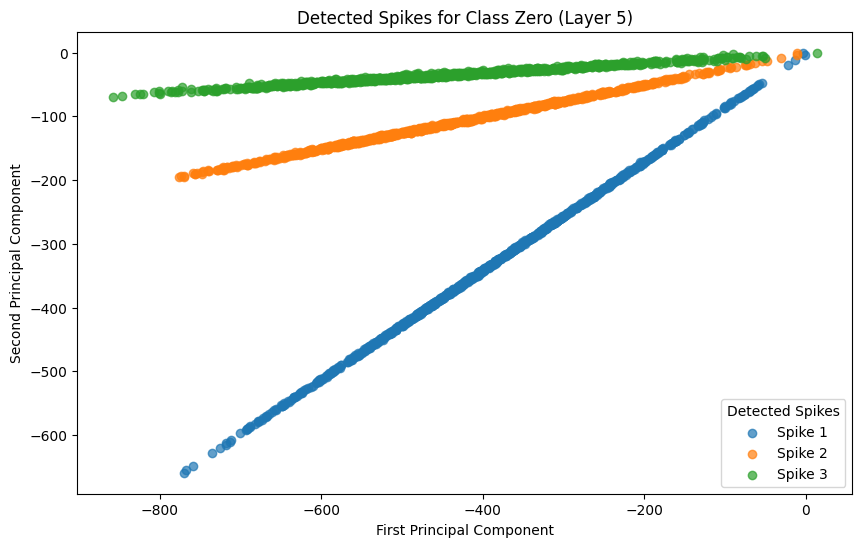

In [7]:
# Plot the detected clusters (spikes) for class zero
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Detected Spikes for Class Zero (Layer 5)')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# Limit the number of spikes to visualize to `num_spikes_per_class`
for i, cluster in enumerate(clusters[:num_spikes_per_class]):
    ax.scatter(cluster[:, 0], cluster[:, 1], label=f'Spike {i + 1}', color=colors[i % len(colors)], alpha=0.7)

ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.legend(title='Detected Spikes')
plt.show()

In [8]:
len(cluster_indices)

5

In [9]:
def spike_tracking_plots(class_idx, idx_layer_original=7):

    num_spikes_per_class = 3
    num_samples_per_spike = 3
    mnist_labels = train_labels.detach().cpu().numpy()
    mnist_data = train_samples.detach().cpu().numpy().reshape(train_samples.shape[0], 28 * 28)
    # Number of classes
    num_classes = len(np.unique(mnist_labels))

    idx_layer_original = 7

    mnist_pca_2d = np.array(results_dict['pca_2'][idx_layer_original]).transpose()

    # Assuming `clusters` and `cluster_indices` are already obtained from the previous task
    anal_path = f'../../spike_analysis/spike_resume_2025/spike_resume_class{class_idx}/'
    os.makedirs(anal_path, exist_ok=True)


    # Extract the data points belonging to the current class
    class_data_indices = np.where(mnist_labels == class_idx)[0]
    class_data = mnist_pca_2d[class_data_indices]

    # Apply iterative line fitting clustering to the class data
    clusters, cluster_indices = iterative_line_fitting(class_data)


    num_layers = len(results_dict['pca_2'])  # Assuming `results_dict['pca_2']` has data for each layer
    layers_to_visualize = list(range(num_layers))  # Visualize all layers

    # Plot the detected clusters (spikes) for class zero
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.set_title('Detected Spikes for Class Zero (Layer 5)')
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

    # Limit the number of spikes to visualize to `num_spikes_per_class`
    for i, cluster in enumerate(clusters):
        ax.scatter(cluster[:, 0], cluster[:, 1], label=f'Spike {i + 1}', color=colors[i % len(colors)], alpha=0.7)

    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.legend(title='Detected Spikes')
    fig.savefig(os.path.join(anal_path, f'spikes_following_for_class_{class_idx}.pdf'))
    plt.close(fig)

    # Extract the data points belonging to the current class
    class_data_indices = np.where(mnist_labels == class_idx)[0]

    # Iterate over each spike cluster
    for spike_idx, spike_indices in tqdm(enumerate(cluster_indices)):
        # Create a figure for each spike
        fig, axes = plt.subplots(1, len(layers_to_visualize), figsize=(25, 5))
        # fig.suptitle(f'Visualization of Spike {spike_idx + 1} Across Different Layers')

        # Loop through each layer to visualize the data
        for idx_layer, ax in zip(layers_to_visualize, axes):
            mnist_pca_2d = np.array(results_dict['pca_2'][idx_layer]).transpose()

            # Plot all data points in the current layer
            ax.scatter(mnist_pca_2d[:, 0], mnist_pca_2d[:, 1], alpha=0.2, label='All Data', color='gray')

            # Extract the data points corresponding to the current spike indices
            selected_data = mnist_pca_2d[class_data_indices][spike_indices]

            # Overlay the data points belonging to the current spike with a different marker
            ax.scatter(selected_data[:, 0], selected_data[:, 1], color='red', marker='+', s=50, label=f'Spike {spike_idx + 1} Data Points')

            ax.set_title(f'Layer {idx_layer}')
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')

        plt.legend()
        plt.tight_layout()

        # Save the figure
        save_path = os.path.join(anal_path, f'spikes_following_for_class_{class_idx}_spike_{spike_idx + 1}.pdf')
        plt.savefig(save_path)
        plt.close(fig)

    print(f'All spike visualizations saved in directory: {anal_path}')


    num_spikes = len(cluster_indices)

    # Create a figure for all spikes and layers
    fig, axes = plt.subplots(num_spikes, len(layers_to_visualize), figsize=(25, 5 * num_spikes))
    fig.suptitle(f'Spike Analysis for Class {class_idx} Across Different Layers\n'
                f'Spikes Originally Detected from Layer {idx_layer_original}', fontsize=16)

    # Loop through each spike and layer to visualize the data
    for spike_idx, spike_indices in enumerate(cluster_indices):
        for idx_layer, ax in zip(layers_to_visualize, axes[spike_idx]):
            mnist_pca_2d = np.array(results_dict['pca_2'][idx_layer]).transpose()

            # Plot all data points in the current layer
            ax.scatter(mnist_pca_2d[:, 0], mnist_pca_2d[:, 1], alpha=0.2, label='All Data', color='gray')

            # Extract the data points corresponding to the current spike indices
            selected_data = mnist_pca_2d[class_data_indices][spike_indices]

            # Overlay the data points belonging to the current spike with a different marker
            ax.scatter(selected_data[:, 0], selected_data[:, 1], color='red', marker='+', s=50, label=f'Spike {spike_idx + 1} Data Points')

            ax.set_title(f'Layer {idx_layer}')
            ax.set_xlabel('First Principal Component')
            ax.set_ylabel('Second Principal Component')

        # Add legend to the first subplot of each row
        axes[spike_idx, 0].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure
    save_path = os.path.join(anal_path, f'spikes_following_for_class_{class_idx}_all_spikes.pdf')
    plt.savefig(save_path)
    plt.close(fig)

    print(f'Spike visualizations for class {class_idx} saved in: {save_path}')




In [10]:
for index_class in tqdm(range(10)):
    spike_tracking_plots(index_class)

5it [01:38, 19.63s/it][00:00<?, ?it/s]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class0/


 10%|█         | 1/10 [03:19<29:58, 199.78s/it]

Spike visualizations for class 0 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class0/spikes_following_for_class_0_all_spikes.pdf


5it [01:37, 19.59s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class1/


 20%|██        | 2/10 [06:44<27:00, 202.53s/it]

Spike visualizations for class 1 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class1/spikes_following_for_class_1_all_spikes.pdf


3it [01:01, 20.58s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class2/


 30%|███       | 3/10 [08:46<19:20, 165.76s/it]

Spike visualizations for class 2 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class2/spikes_following_for_class_2_all_spikes.pdf


5it [01:43, 20.67s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class3/


 40%|████      | 4/10 [12:10<18:05, 180.86s/it]

Spike visualizations for class 3 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class3/spikes_following_for_class_3_all_spikes.pdf


5it [01:39, 19.82s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class4/


 50%|█████     | 5/10 [15:30<15:39, 187.93s/it]

Spike visualizations for class 4 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class4/spikes_following_for_class_4_all_spikes.pdf


2it [00:39, 19.85s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class5/


 60%|██████    | 6/10 [16:52<10:07, 151.84s/it]

Spike visualizations for class 5 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class5/spikes_following_for_class_5_all_spikes.pdf


5it [01:36, 19.36s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class6/


 70%|███████   | 7/10 [20:16<08:26, 168.88s/it]

Spike visualizations for class 6 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class6/spikes_following_for_class_6_all_spikes.pdf


5it [01:38, 19.76s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class7/


 80%|████████  | 8/10 [23:36<05:57, 178.76s/it]

Spike visualizations for class 7 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class7/spikes_following_for_class_7_all_spikes.pdf


5it [01:37, 19.47s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class8/


 90%|█████████ | 9/10 [27:00<03:06, 186.75s/it]

Spike visualizations for class 8 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class8/spikes_following_for_class_8_all_spikes.pdf


5it [01:43, 20.64s/it]


All spike visualizations saved in directory: ../../spike_analysis/spike_resume_2025/spike_resume_class9/


100%|██████████| 10/10 [30:22<00:00, 182.27s/it]

Spike visualizations for class 9 saved in: ../../spike_analysis/spike_resume_2025/spike_resume_class9/spikes_following_for_class_9_all_spikes.pdf
